# RECOVAR visualization and analysis (copied from cryoDRGN's)

This jupyter notebook provides a template for analyzing results, including:
* plotting of mean, mask and eigenvector
* resolution of mean and decay of eigenvalues
* latent space visualization with PCA/UMAP
* clustering
* trajectories
<!-- * interactive visualization of the latent space, imaging, and pose parameters -->
<!-- * interactive selection of particle images from the latent space -->
<!-- * interactive generation of volumes from the latent space -->

Note that this is a simple template for data analysis, and not a polished UI. Experience with Python/Pandas is recommended.

In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import pickle
import subprocess
import os, sys

from cryodrgn import analysis
from cryodrgn import utils
# from cryodrgn import dataset
from cryodrgn import ctf
from recovar import plot_utils
from recovar import output, dataset

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from ipywidgets import interact, interactive, HBox, VBox
from scipy.spatial.transform import Rotation as RR
py.init_notebook_mode()
from IPython.display import FileLink, FileLinks

In [2]:
# Enable interactive widgets
# !jupyter nbextension enable --py widgetsnbextension

### Load result from pipeline.py

In [3]:
# Specify the result dir
recovar_result_dir = ''
recovar_result_dir = '/home/mg6942/mytigress/uniform/test-new/'

In [4]:
# Load z
results = output.load_results_new(recovar_result_dir)
cryos = dataset.load_dataset_from_args(results['input_args'], lazy = True)
z_dim_used = 4#list(results['zs'].keys())[-1]
print("available zdim:", list(results['zs'].keys()), "using:", z_dim_used)
z = results['zs'][z_dim_used]

(INFO) (dataset.py) (22-Oct-23 09:17:44) Loading halfset from file
(INFO) (ctf.py) (22-Oct-23 09:17:44) Image size (pix)  : 128
(INFO) (ctf.py) (22-Oct-23 09:17:44) A/pix             : 6.0
(INFO) (ctf.py) (22-Oct-23 09:17:44) DefocusU (A)      : 26795.69921875
(INFO) (ctf.py) (22-Oct-23 09:17:44) DefocusV (A)      : 26795.69921875
(INFO) (ctf.py) (22-Oct-23 09:17:44) Dfang (deg)       : 0.0
(INFO) (ctf.py) (22-Oct-23 09:17:44) voltage (kV)      : 300.0
(INFO) (ctf.py) (22-Oct-23 09:17:44) cs (mm)           : 2.0
(INFO) (ctf.py) (22-Oct-23 09:17:44) w                 : 0.10000000149011612
(INFO) (ctf.py) (22-Oct-23 09:17:44) Phase shift (deg) : 0.0
(INFO) (ctf.py) (22-Oct-23 09:17:45) Image size (pix)  : 128
(INFO) (ctf.py) (22-Oct-23 09:17:45) A/pix             : 6.0
(INFO) (ctf.py) (22-Oct-23 09:17:45) DefocusU (A)      : 26795.69921875
(INFO) (ctf.py) (22-Oct-23 09:17:45) DefocusV (A)      : 26795.69921875
(INFO) (ctf.py) (22-Oct-23 09:17:45) Dfang (deg)       : 0.0
(INFO) (ctf.py) (

# Diagnostics
* if the mask looks very wrong, it is likely that the uninvert-data is poorly set. 
Use --uninvert-data=true (or false, depending on what you set before). 
If you use automatic, then you can check what it chose and take the oposite by looking at:
print(results['input_args'].uninvert_data)

* If the first eigenvector is mostly positive and looks like the mean, your data might have significant contrast.
Use the --correct-contrast option

(INFO) (xla_bridge.py) (22-Oct-23 09:17:46) Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
(INFO) (xla_bridge.py) (22-Oct-23 09:17:46) Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


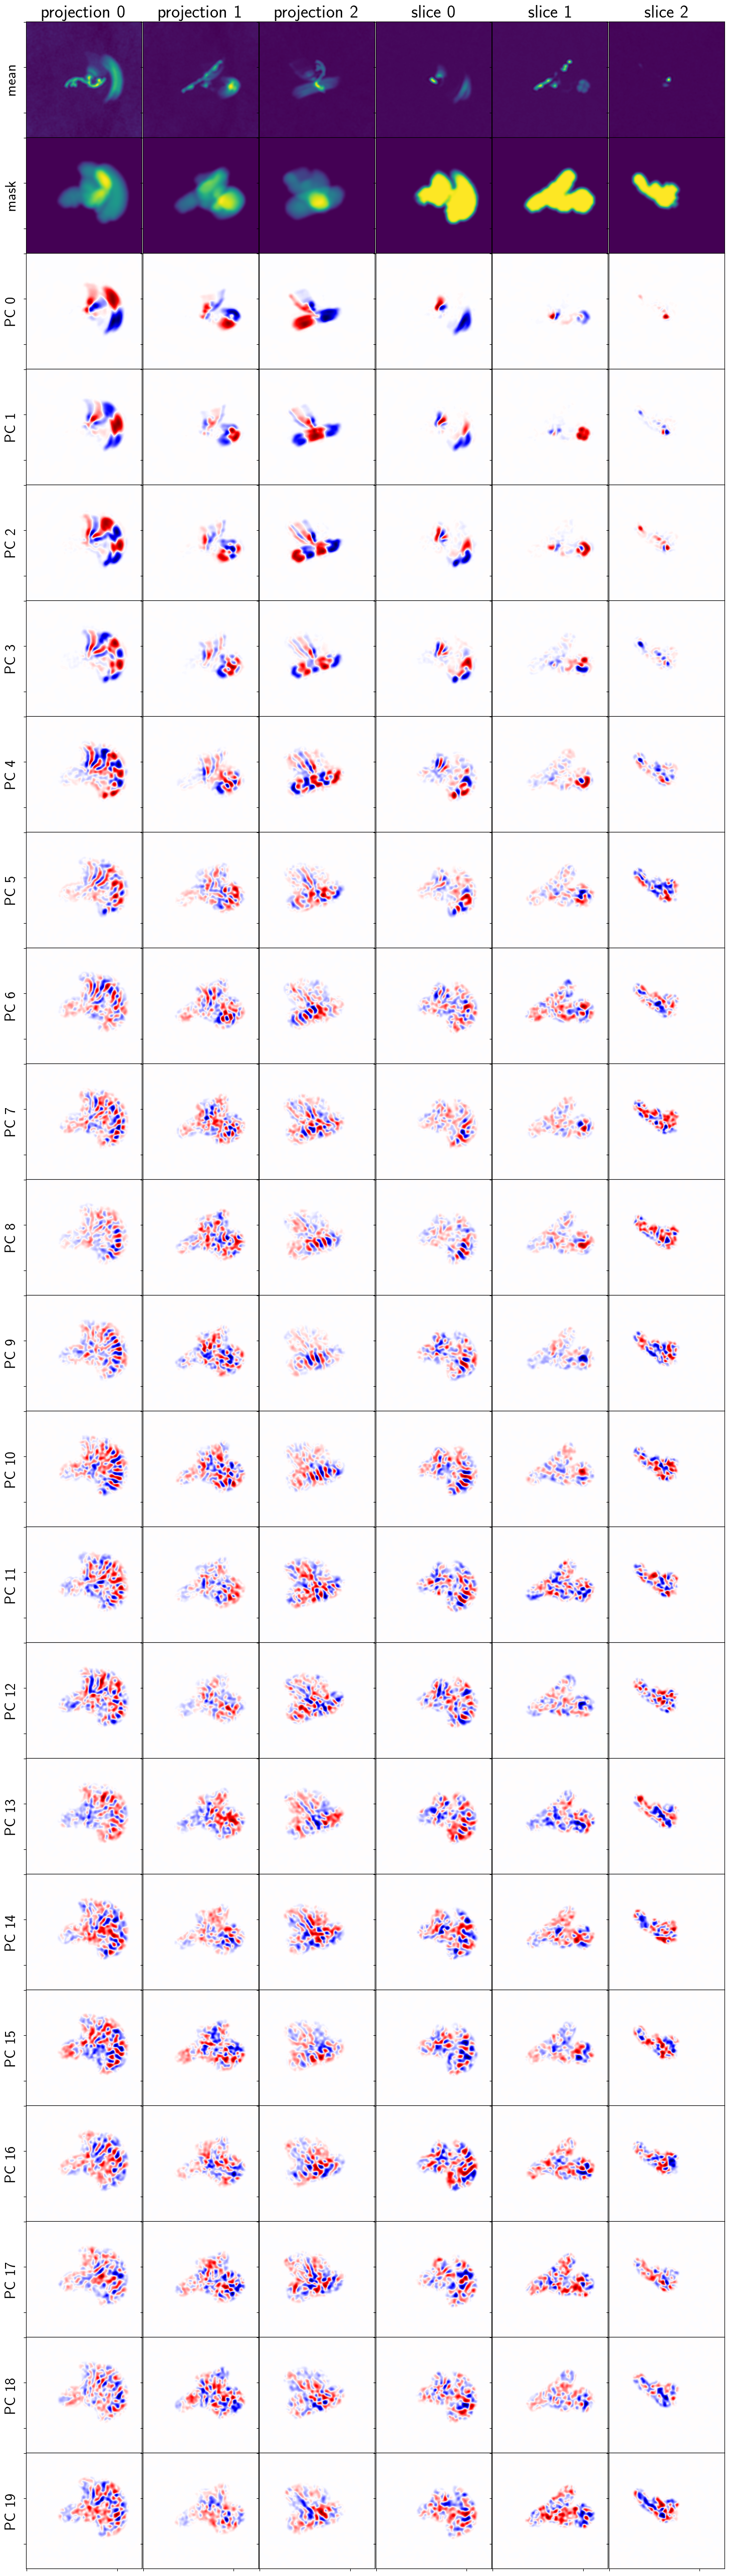

In [5]:
reload(plot_utils)
plot_utils.plot_summary_t(results,cryos, n_eigs=20)

{}

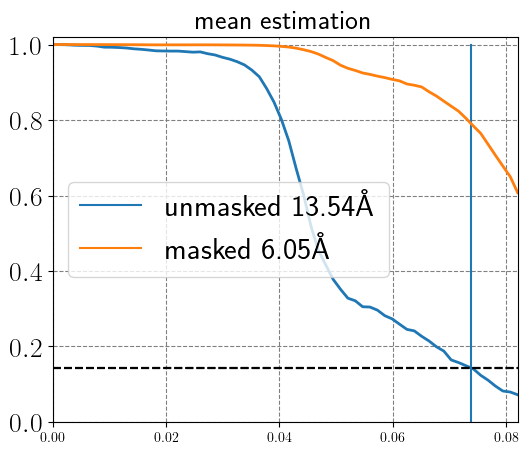

<Figure size 600x500 with 0 Axes>

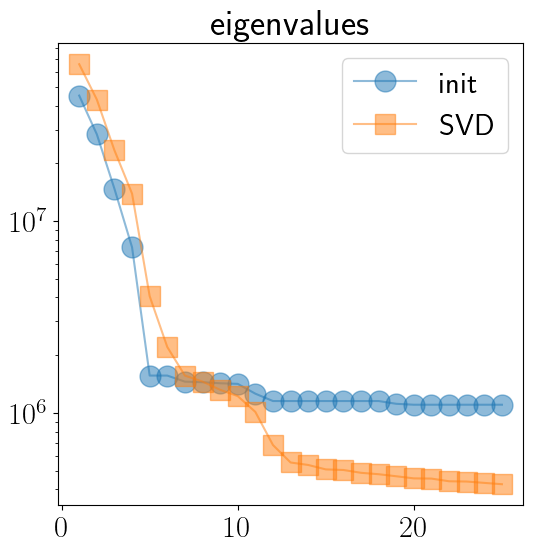

<Figure size 600x600 with 0 Axes>

In [6]:
# Plot FSC of mean, decay of eigenvalues
plot_utils.plot_mean_fsc(results, cryos)
plot_utils.plot_cov_results(results['u'], results['s'])

### Load result from analyze

In [7]:
# If you changed the output dir, specify it here
analysis_dir = f'{recovar_result_dir}output/analysis_{z_dim_used}'

# Load UMAP
umap = utils.load_pkl(f'{analysis_dir}/umap_embedding.pkl')
# or run UMAP
# umap = analysis.run_umap(z)

In [8]:
# Load kmeans
K = 40
# kmeans_labels = utils.load_pkl(f'{WORKDIR}/analyze.{EPOCH}/kmeans{K}/labels.pkl')
kmeans_results = utils.load_pkl(f'{analysis_dir}/kmeans_{K}/centers.pkl')
kmeans_centers = kmeans_results['centers']
kmeans_labels = kmeans_results['labels']

# Or re-run kmeans with the desired number of classes
# kmeans_labels, kmeans_centers = analysis.cluster_kmeans(z, 20)

# # Get index for on-data cluster center
kmeans_centers, centers_ind = analysis.get_nearest_point(z, kmeans_centers)

### Load dataset

In [9]:
# Convert rotation matrices to euler angles
rots = np.concatenate([cryo.rotation_matrices for cryo in cryos])
euler = RR.from_matrix(rots).as_euler('zyz', degrees=True)
trans = np.concatenate([cryo.translations for cryo in cryos])
ctf_params = np.concatenate([cryo.CTF_params for cryo in cryos])
ctf.print_ctf_params(ctf_params[0])

(INFO) (ctf.py) (22-Oct-23 09:17:59) Image size (pix)  : 27937
(INFO) (ctf.py) (22-Oct-23 09:17:59) A/pix             : 27937.390625
(INFO) (ctf.py) (22-Oct-23 09:17:59) DefocusU (A)      : 0.0
(INFO) (ctf.py) (22-Oct-23 09:17:59) DefocusV (A)      : 300.0
(INFO) (ctf.py) (22-Oct-23 09:17:59) Dfang (deg)       : 2.0
(INFO) (ctf.py) (22-Oct-23 09:17:59) voltage (kV)      : 0.10000000149011612
(INFO) (ctf.py) (22-Oct-23 09:17:59) cs (mm)           : 0.0
(INFO) (ctf.py) (22-Oct-23 09:17:59) w                 : 0.0
(INFO) (ctf.py) (22-Oct-23 09:17:59) Phase shift (deg) : 1.0


### Learning curve

### PCA

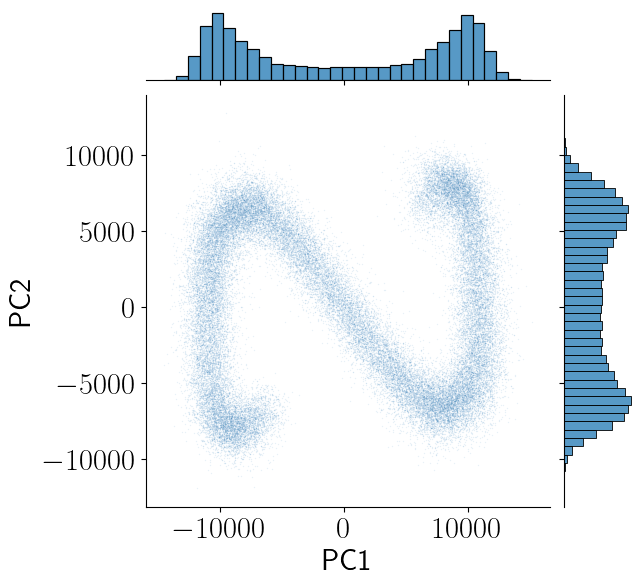

In [10]:
pc = z
g = sns.jointplot(x=pc[:,0], y=pc[:,2], alpha=.1, s=1)
g.set_axis_labels('PC1', 'PC2')

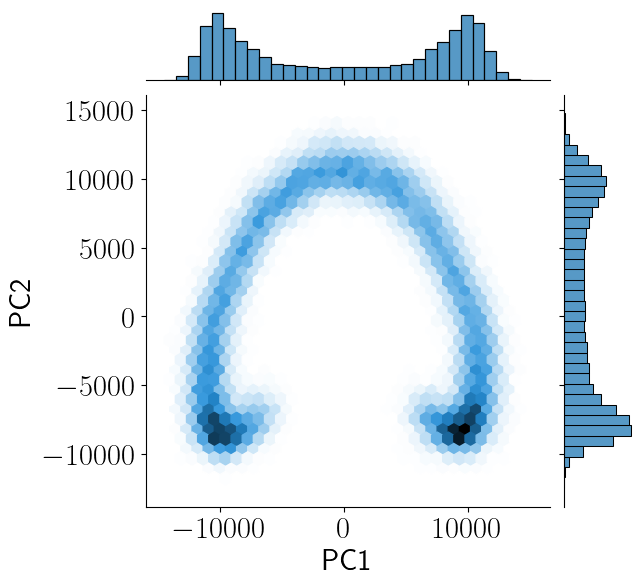

In [11]:
g = sns.jointplot(x=pc[:,0], y=pc[:,1], kind='hex')
g.set_axis_labels('PC1', 'PC2')

Text(0, 0.5, 'explained variance')

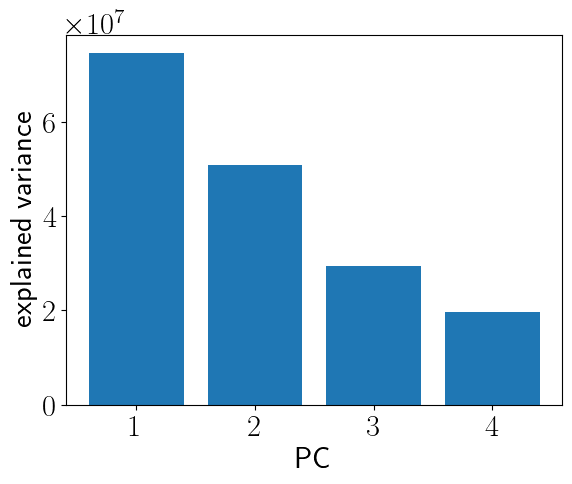

In [12]:
plt.bar(np.arange(z.shape[1])+1,np.var(z, axis=0))
plt.xticks(np.arange(z.shape[1])+1)
plt.xlabel('PC')
plt.ylabel('explained variance')

### View UMAP

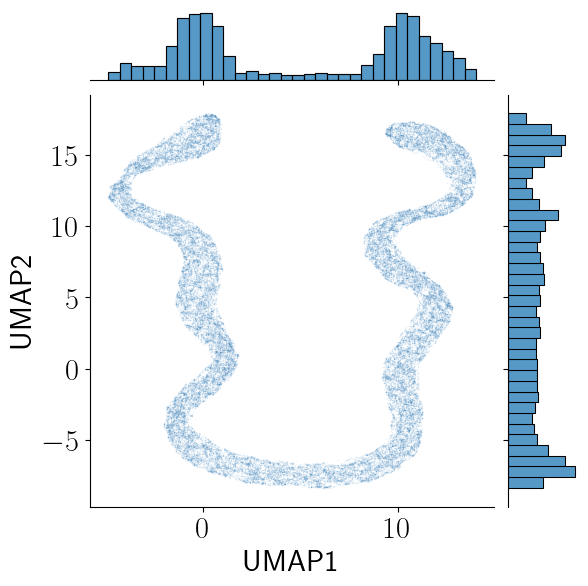

In [13]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], alpha=.1, s=1)
g.set_axis_labels('UMAP1', 'UMAP2')

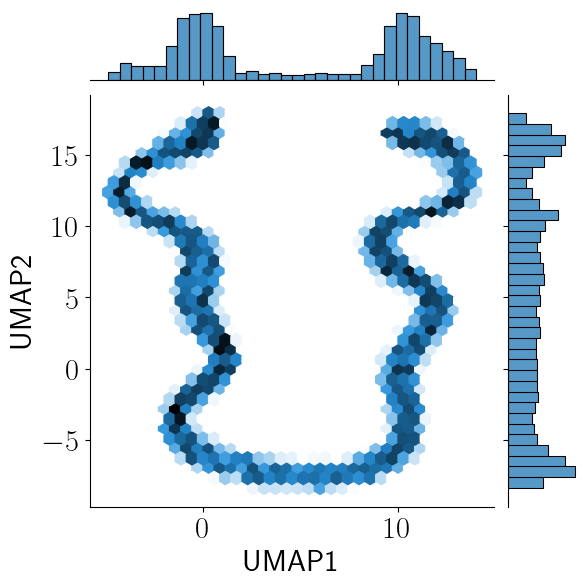

In [14]:
g = sns.jointplot(x=umap[:,0], y=umap[:,1], kind='hex')
g.set_axis_labels('UMAP1', 'UMAP2')

### View pose and shift distribution 

(INFO) (ctf.py) (22-Oct-23 09:18:01) Image size (pix)  : 27937
(INFO) (ctf.py) (22-Oct-23 09:18:01) A/pix             : 27937.390625
(INFO) (ctf.py) (22-Oct-23 09:18:01) DefocusU (A)      : 0.0
(INFO) (ctf.py) (22-Oct-23 09:18:01) DefocusV (A)      : 300.0
(INFO) (ctf.py) (22-Oct-23 09:18:01) Dfang (deg)       : 2.0
(INFO) (ctf.py) (22-Oct-23 09:18:01) voltage (kV)      : 0.10000000149011612
(INFO) (ctf.py) (22-Oct-23 09:18:01) cs (mm)           : 0.0
(INFO) (ctf.py) (22-Oct-23 09:18:01) w                 : 0.0
(INFO) (ctf.py) (22-Oct-23 09:18:01) Phase shift (deg) : 1.0


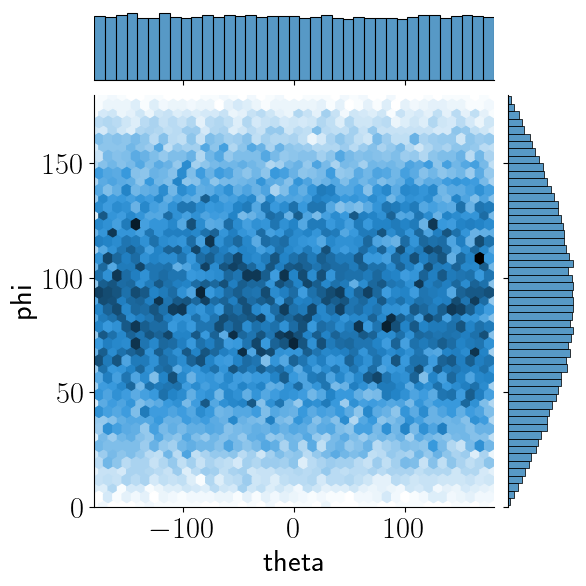

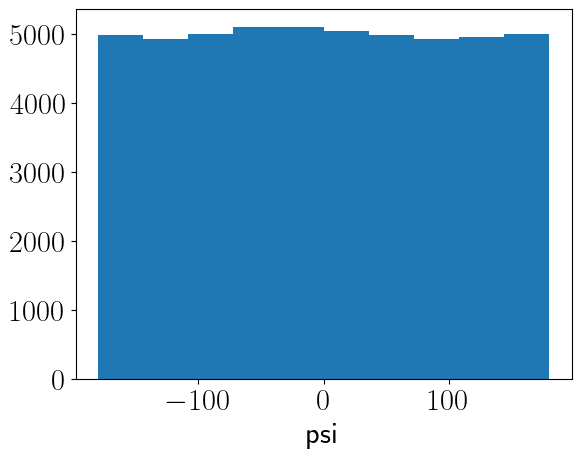

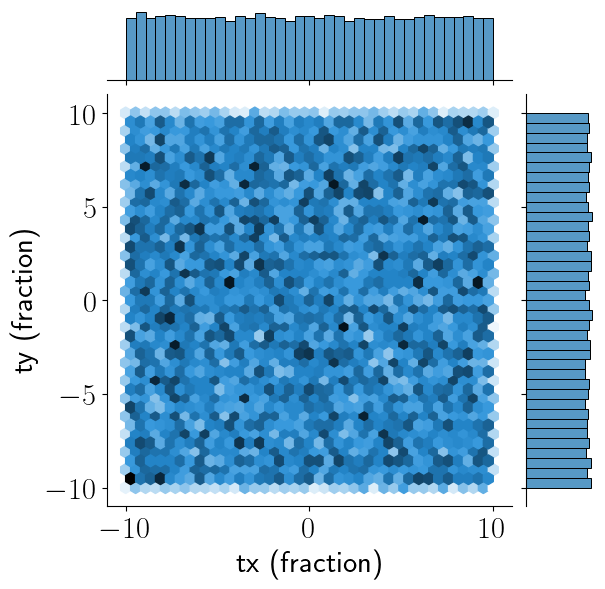

In [15]:
# Convert rotation matrices to euler angles
rots = np.concatenate([cryo.rotation_matrices for cryo in cryos])
euler = RR.from_matrix(rots).as_euler('zyz', degrees=True)
trans = np.concatenate([cryo.translations for cryo in cryos])
ctf_params = np.concatenate([cryo.CTF_params for cryo in cryos])
ctf.print_ctf_params(ctf_params[0])
# rotations
analysis.plot_euler(euler[:,0],euler[:,1], euler[:,2])
sns.jointplot(x=trans[:,0],
              y=trans[:,1],
              kind='hex').set_axis_labels('tx (fraction)','ty (fraction)')

### View K-means clusters

Text(0, 0.5, 'PC2')

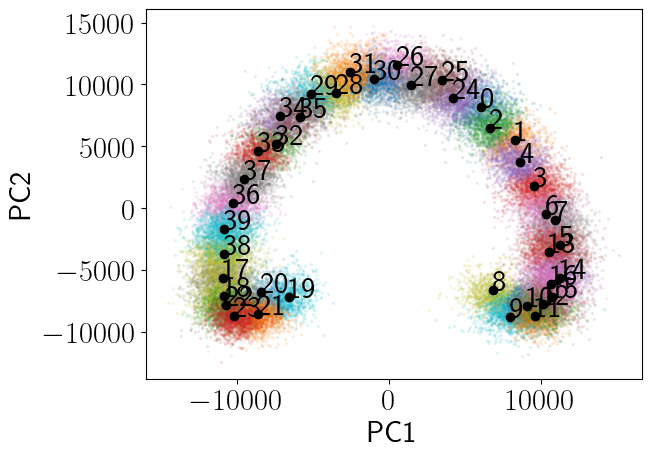

In [16]:
K = len(set(kmeans_labels))
c = kmeans_centers
analysis.plot_by_cluster(pc[:,0], pc[:,1], K, 
                         kmeans_labels, 
                         centers=c,
                         annotate=True)
plt.xlabel('PC1')
plt.ylabel('PC2')

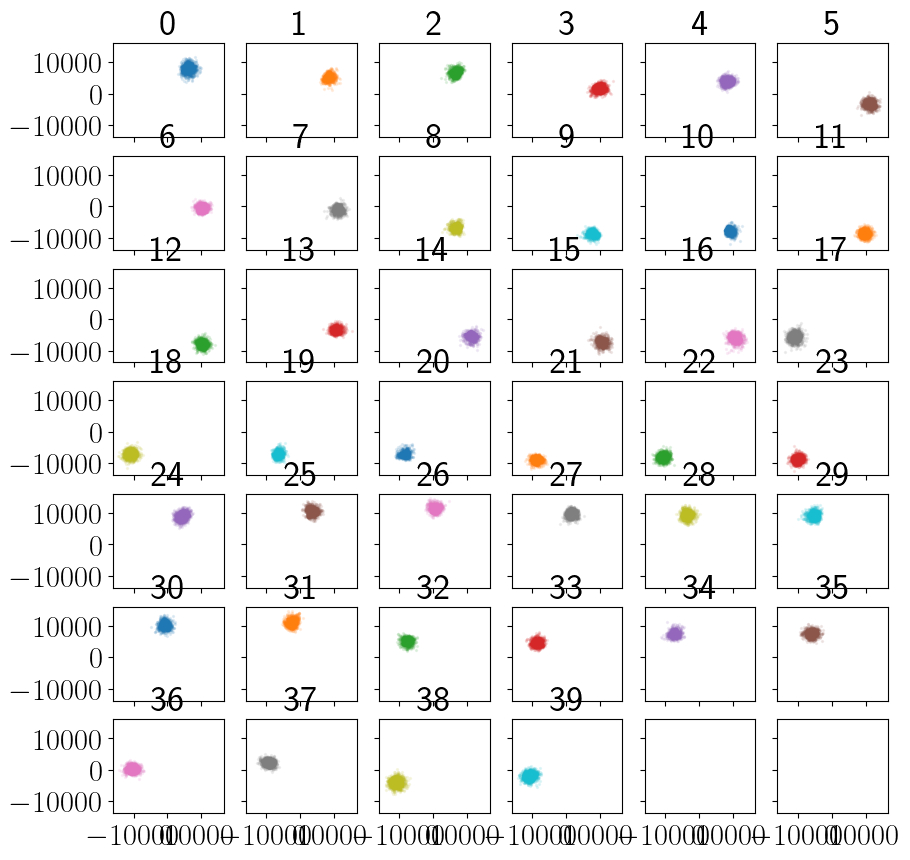

In [17]:
fig, ax = analysis.plot_by_cluster_subplot(pc[:,0], pc[:,1], K, 
                            kmeans_labels)

Text(0, 0.5, 'UMAP2')

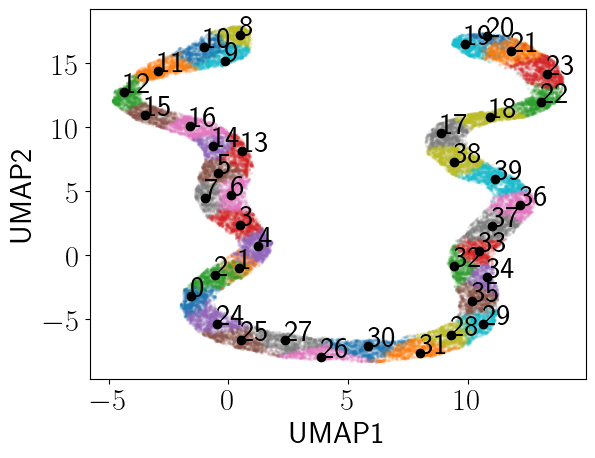

In [18]:
analysis.plot_by_cluster(umap[:,0], umap[:,1], K, 
                         kmeans_labels, 
                         centers_ind=centers_ind,
                         annotate=True)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

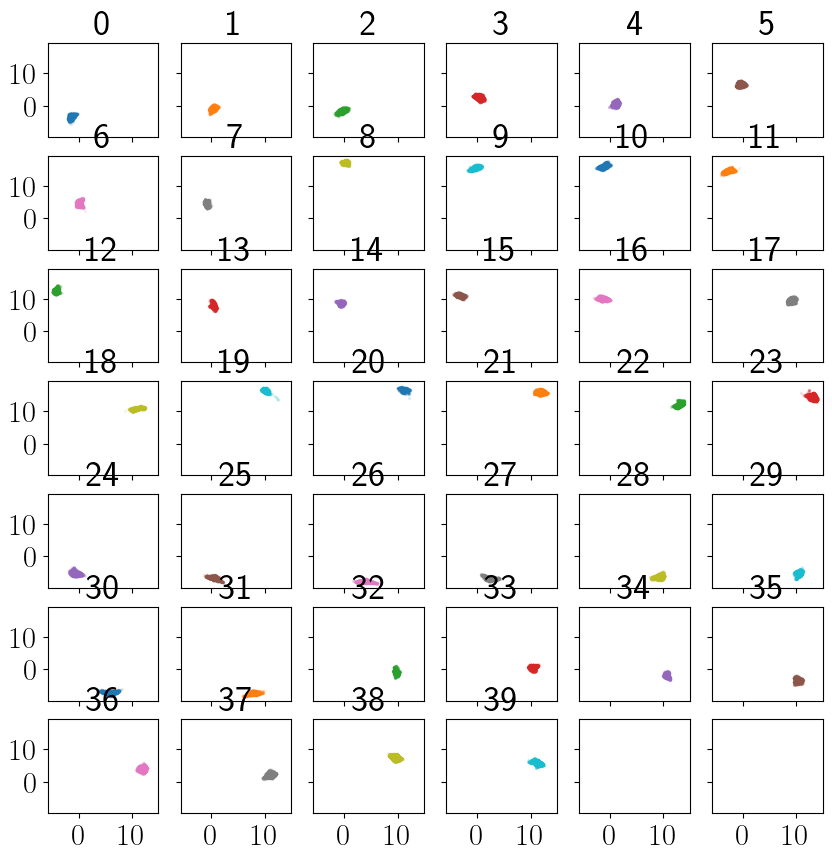

In [19]:
fig, ax = analysis.plot_by_cluster_subplot(umap[:,0], umap[:,1], K, 
                            kmeans_labels)

### Load one of the trajectories and plot it over density

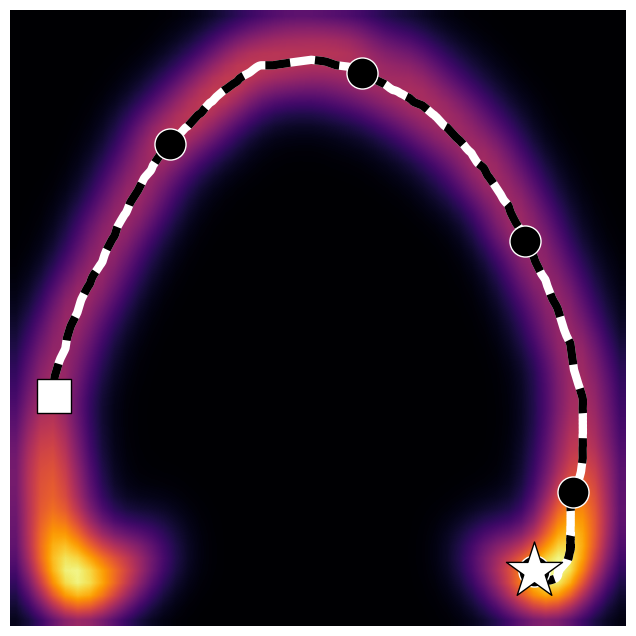

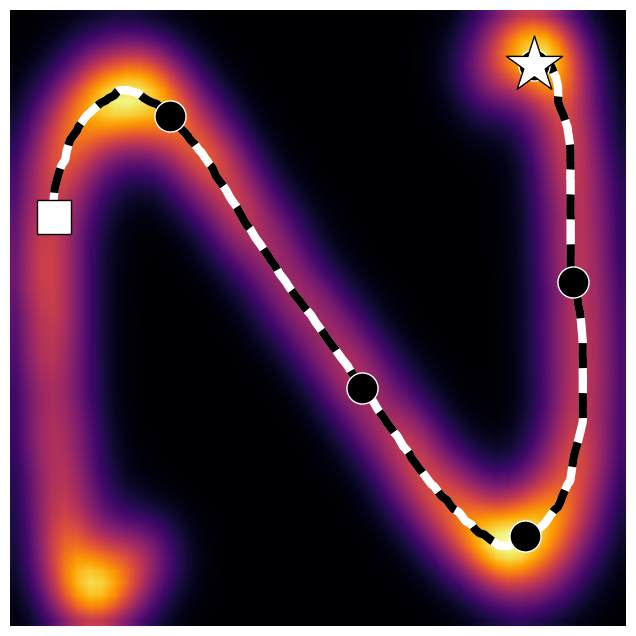

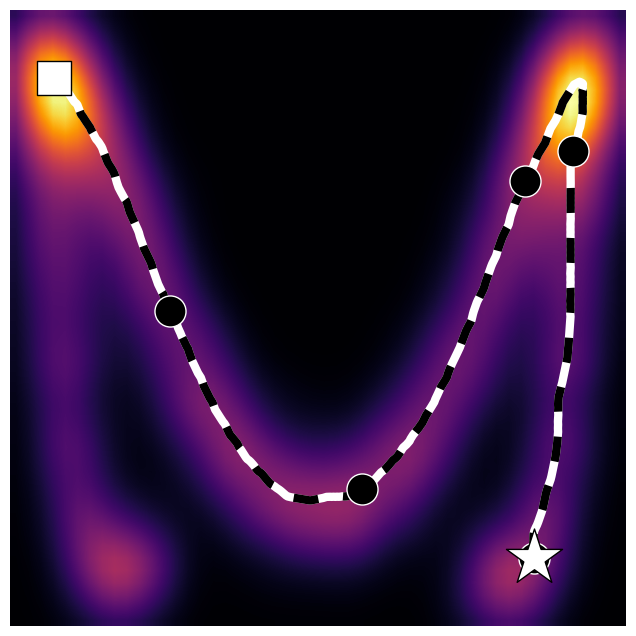

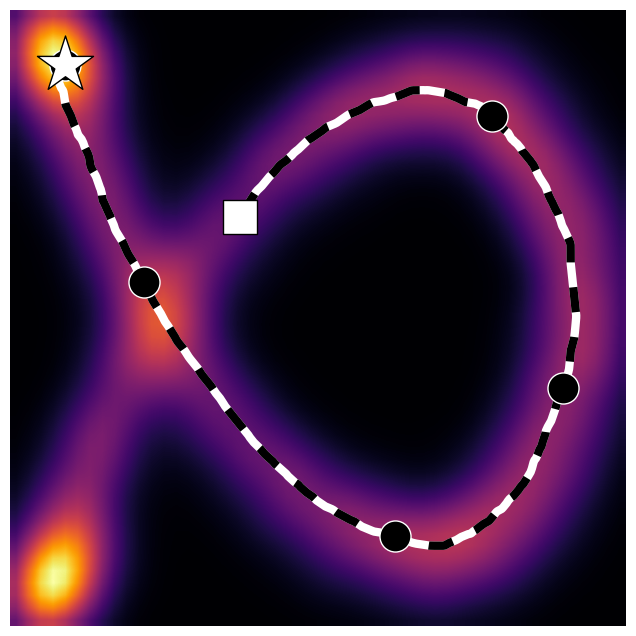

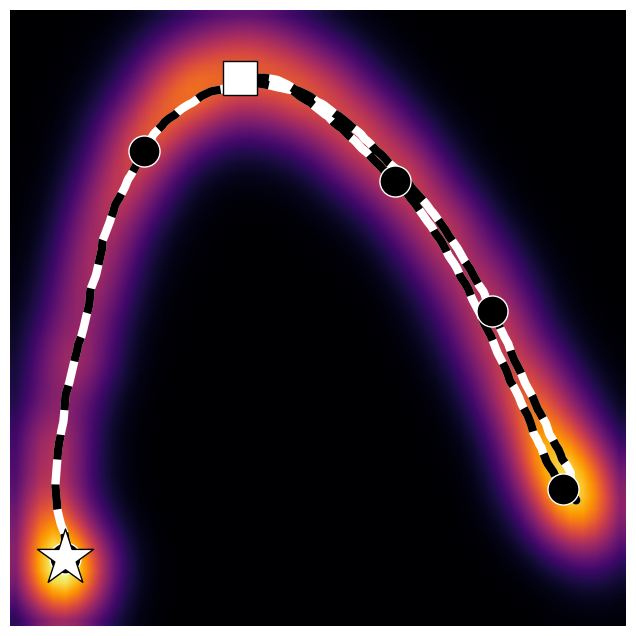

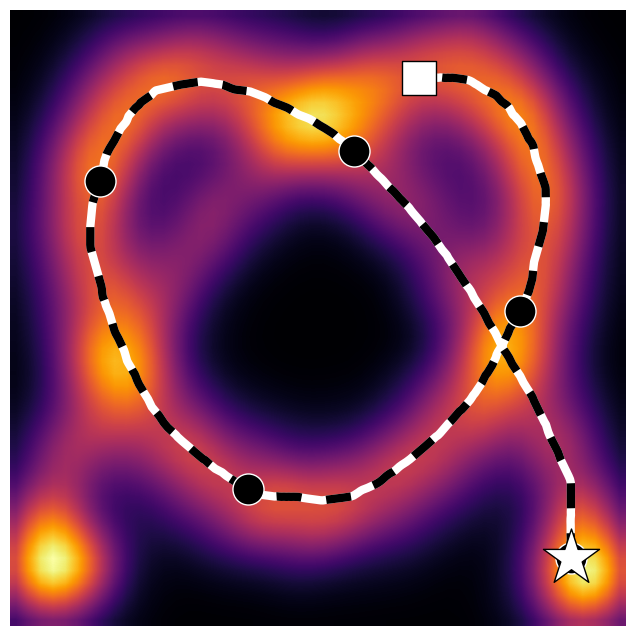

In [27]:
import json
path_r = json.load(open(f'{analysis_dir}/kmeans_{K}/path2/path.json', 'rb'))
path = np.array(path_r['path'])
subsampled = np.array(path_r['path_subsampled'])
output.plot_trajectories_over_density_from_result(results, [path], [subsampled], zdim=4 )


In [ ]:
## Or compute a new one between two end points
from compute_trajectory import compute_trajectory
# # zdim, z_st, z_end, output_folder
# z_st = kmeans_centers[1]
# z_end = kmeans_centers[35]
# compute_trajectory(results, z_dim_used, z_st, z_end, output_folder = f'{analysis_dir}/kmeans_{K}/path_test' )


# Interactive visualization

Interactive visualization of the latent encodings for the trained model. Each point represents a particle image of the dataset. The hover text includes the index of the image in the particle stack. 

### Load into pandas dataframe

In [ ]:
# Load data into a pandas dataframe
df = analysis.load_dataframe(z=z, 
                             pc=pc, 
                             euler=euler, 
                             trans=trans, 
                             labels=kmeans_labels, 
                             umap=umap,
                             df1=ctf_params[:,2],
                             df2=ctf_params[:,3],
                             dfang=ctf_params[:,4],
                             phase=ctf_params[:,8])
df.head()

In [ ]:
# Annotated points correspond to kmeans cluster centers
widget, fig = analysis.ipy_plot_interactive_annotate(df,centers_ind)
VBox((widget,fig))

# Interactive selection

The next two cells contain helper code to select particles using an interactive lasso tool. 

1. In the first cell, select points with the lasso tool. The table widget is dynamically updated with the most recent selection's indices. 
2. Then once you've finalized your selection, use the next cell to save the particle indices for downstream analysis/viz.

(Double click to clear selection)

In [ ]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df)
VBox((widget,fig,ind_table))

In [ ]:
ind_selected = ind_table.data[0].cells.values[0] # save table values
ind_selected = np.array(ind_selected)
ind_selected_not = np.array(sorted(set(np.arange(len(df))) - set(ind_selected)))

print('Selected indices:')
print(ind_selected)
print('Number of selected points:')
print(len(ind_selected))
print('Number of unselected points:')
print(len(ind_selected_not))

### Visualize selected subset

In [ ]:
# View PCA
plt.scatter(pc[:,0], pc[:,1], alpha=.1, s=1)
plt.scatter(pc[ind_selected,0], pc[ind_selected,1], alpha=.1, s=1)
plt.xlabel('PC1 ({:.2f})'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.2f})'.format(pca.explained_variance_ratio_[1]))

In [ ]:
# View umap
plt.scatter(umap[:,0], umap[:,1], alpha=.1, s=1)
plt.scatter(umap[ind_selected,0], umap[ind_selected,1], alpha=.1, s=1)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

In [ ]:
# Subset of dataframe
df_sub = df.loc[ind_selected]
df_sub_not = df.loc[ind_selected_not]

In [ ]:
# View pose distribution
analysis.plot_euler(df_sub.theta, df_sub.phi, df_sub.psi)

In [ ]:
widget, fig, ind_table = analysis.ipy_plot_interactive(df_sub)
VBox((widget,fig,ind_table))

In [ ]:
# import plotly
# import numpy as np
# X = np.random.randn(10,3)
# from recovar import plot_utils
# plot_utils.plotly_scatter([X])
# # import plotly.express as px
# # fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
# # fig.write_html('first_figure.html', auto_open=True)


### Save the index selection

The indices for the selected particles may be saved for use in downstream processing in cryoDRGN or with other tools. Within cryoDRGN, selections are saved as an index array in `.pkl` file format. Then, the selected indices can be provided to cryoDRGN with the `--ind` argument to train a new model on a subset of the images. 

Tools are provided in the `utils` subdirectory of the cryoDRGN repo to help convert the index selection to `.star` file format.

**NOTE:** If there are multiple rounds of index filtering performed on the same particle stack (i.e. your results come from a training run that already uses an --ind subselection), the index selection must be converted into the correct indices into the original dataset.

In [ ]:
#SAVE_PATH = f'{WORKDIR}/ind_selected.pkl' # RENAME ME

## IMPORTANT: convert index selection to original particles indices if current results have already been filtered

#if ind_orig is not None:
#    ind_selected_orig = analysis.convert_original_indices(ind_selected, N_orig, ind_orig)
#    utils.save_pkl(ind_selected_orig, SAVE_PATH)

#else:
#    utils.save_pkl(ind_selected, SAVE_PATH)

# View particles

View images at selected points in latent space

In [ ]:
particle_ind = ind_selected # or set to custom selection

In [ ]:
# choose 9 particles to view at random
if len(particle_ind) > 9:
    ind_subset9 = np.random.choice(particle_ind, 9, replace=False)
else: 
    ind_subset9 = particle_ind
print(ind_subset9)

In [ ]:
particle_ind

In [ ]:
p = [cryos[0].get_image_real(ii % cryos[0].n_images) for ii in ind_subset9]
analysis.plot_projections(p, ind_subset9)
widget, fig = analysis.ipy_plot_interactive_annotate(df, ind_subset9, opacity=.1)
VBox((widget,fig))

# Generate volumes

Generate volumes at selected points in latent space

In [ ]:
vol_ind = [] # ADD INDICES HERE
print(vol_ind)

In [ ]:
widget, fig = analysis.ipy_plot_interactive_annotate(df, vol_ind, opacity=.1)
VBox((widget,fig))

In [ ]:
def get_outdir():
    '''Helper function to get a clean directory to save volumes'''
    for i in range(100000):
        outdir = f'reconstruct_{i:06d}'
        if os.path.exists(outdir): continue
        else: break
    return outdir

def generate_volumes(zvalues, outdir, **kwargs):
    '''Helper function to call cryodrgn eval_vol and generate new volumes'''
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    np.savetxt(f'{outdir}/zfile.txt', zvalues)
    analysis.gen_volumes(f'{WORKDIR}/weights.{EPOCH}.pkl',
                         f'{WORKDIR}/config.pkl',
                         f'{outdir}/zfile.txt',
                         f'{outdir}', **kwargs)
    return FileLinks(f'{outdir}/')

In [ ]:
# # Get a unique output directory, or define your own
# outdir = get_outdir()
# print(os.path.abspath(outdir))

In [ ]:
# Modify any defaults for volume generation -- see `cryodrgn eval_vol -h` for details 
Apix = 1 # Set to volume pixel size
flip = False # Hand flip?
invert = False # Invert contrast?
downsample = None # Set to smaller box size if desired
cuda = None # specify cuda device

generate_volumes(z[vol_ind], outdir, Apix=cryos[0].voxel_size, flip=flip, downsample=downsample, cuda=cuda, invert=invert)